IndexError: single positional indexer is out-of-bounds

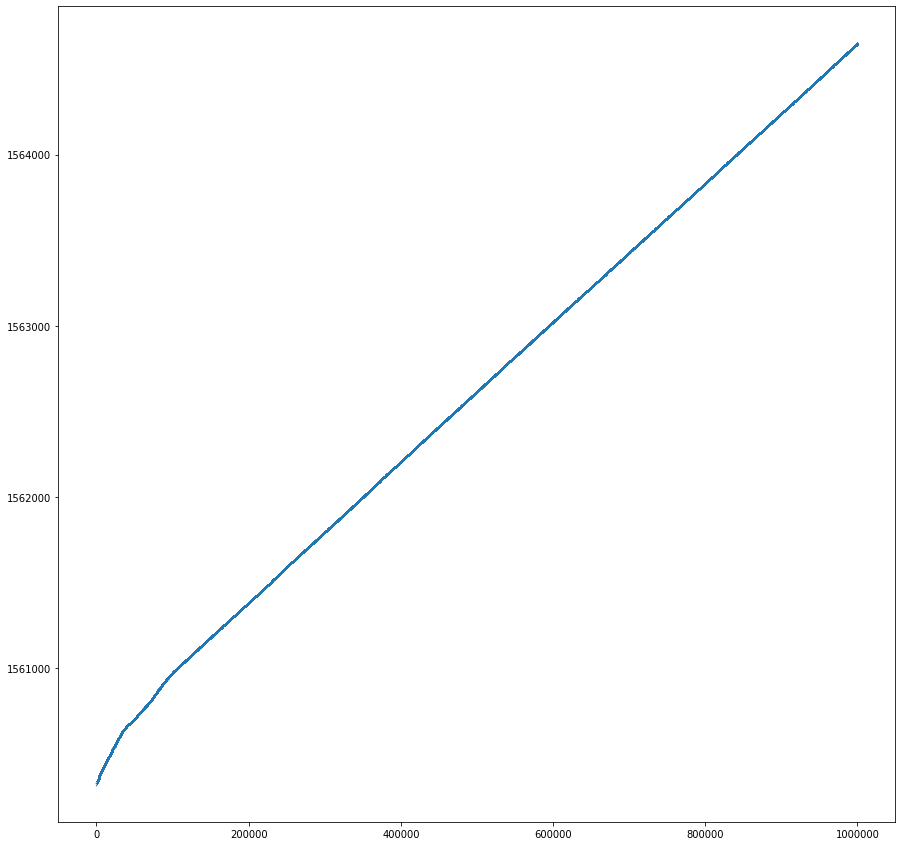

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy import nan
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
import time

def main():
    data = pd.read_csv("/Users/dblab/raw193.csv")
    data = data.sort_values(['nvme_sq'],ascending="False")
    data = data[data!=0]
    data = data.reset_index(drop=True)

    data1 = data.copy()
    data1 = data1['block_rq_complete']
    plt.figure(figsize=(15,15))
    plt.scatter(range(0,1000000),data1[0:1000000],s=0.1)
    data = data['block_rq_complete']
    #print(data)
    
    zero_data = data[data==0]
    zero_data = zero_data.reset_index()
    zero_data['index_Difference'] = zero_data['index']
    zero_data['index_Difference'] = zero_data['index_Difference'] - zero_data['index_Difference'].shift(1,fill_value=0)
    zero_temp = zero_data[zero_data['index_Difference']>1]
    zero_temp = zero_temp.reset_index()
    
    zero_temp['level_0'] = zero_temp['level_0'].shift(-1) - zero_temp['level_0']
    nan_value = zero_data.iloc[-1]['index'] - zero_temp.iloc[-1]['index'] + 1
    zero_temp = zero_temp.replace(nan,nan_value)
    zero_temp['level_0'] = zero_temp['level_0']
    print(zero_temp)
    #print(len(zero_temp))
    
    len_pred = 100
    len_train = 1000
    for i in range(len(zero_temp)):
        test = zero_temp.iloc[i]['level_0'].astype('int64')
        train = zero_temp.iloc[i]['index'].astype('int64')
        print("test :",test)
        print("train :",train)
        if test > len_pred:
            while test >= len_pred:
                if train < len_train:
                    data_temp = data[train-train:train]
                    data[train:train+test] = My_arima(data_temp,train,test)
                    mae(data[train:train+test], data1[train:train+test])
                    train = train + len_pred
                    test = test - len_pred
                    print("part0")
                    print(data_temp)
                    
                else:
                    data_temp = data[train-len_train:train]
                    data[train:train+test] = My_arima(data_temp,train,test)
                    mae(data[train:train+test], data1[train:train+test])
                    test = test - len_pred
                    train = train + len_pred
                    print("part1")
                    print(data_temp)

        else:
            if train < len_train:
                data_temp = data[train - train:train]
                data[train:train+test] = My_arima(data_temp,train,test)
                mae(data[train:train+test], data1[train:train+test])
                print("part2")
            else:
                data_temp = data[train - len_train:train]
                data[train:train+test] = My_arima(data_temp,train,test)
                mae(data[train:train+test], data1[train:train+test])
                print("part3")
    
    #print(zero_temp)
    #print(zero_data)
    

    # mae
def mae(forecast,original):
    forecast = np.array(forecast).reshape(-1,1)
    original = np.array(original).reshape(-1,1)
    error_mean = np.mean(np.abs(original - forecast), axis=0)
    print("mae : ",error_mean)
    
    # ARIMA Model
def My_arima(data_temp,train,test):
    
    # P-value Check
    result = adfuller(data_temp)
    print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
    print(f'원 데이터 p-value: {result[1]:.3f}')
    #data_temp = data_temp.diff().dropna()
    #reslut = adfuller(data_temp)
    #print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
    #print(f'1차 차분 p-value: {result[1]:.3f}')
    
    # ARIMA Parameter Select
    list_arima = my_auto_arima(data_temp, [3,3,3])
    
    model = ARIMA(data_temp, order=(int(list_arima[0]),int(list_arima[1]),int(list_arima[2])))
    model_fit = model.fit()
    print(model_fit.summary())
    forecast = model_fit.forecast(steps=test)[0]
    forecast = pd.Series(forecast)
    
    forecast.index = list(range(train,train+test))
    #print("forecast")
    #test_data = data1[train:train+test]
    #print("Original")
    #print(test_data)
    #data[train:train+test] = forecast
    return forecast
    #print("input to data")
    #print(data[train:train+test])

    # plot
    #plt.figure(figsize=(15,15))
    #plt.subplot(5,1,1)
    #plt.title("Original Data")
    #plt.plot(test_data)
    #plt.subplot(5,1,2)
    #plt.title("Forecast Data")
    #plt.plot(forecast)
    #plt.subplot(5,1,3)
    #plt.plot(test_data)
    #plt.plot(forecast)

def my_auto_arima(data, order,sort = 'AIC'):
    
    import re
    
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    #bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    #bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    str_data = result_df.iloc[0]['order']
    numbers = re.findall('\d+',str_data)
    return numbers
main()